# 1. Setup

## 1-1. Library Setup

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import os

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8838164934089963602
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11511531391578272884
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!nvidia-smi

Wed Dec 15 14:32:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. Hyperparameter setup

In [ ]:
# Dataset hyperparameters
image_size = 128
image_channels = 3

# Algorithm hyperparameters
num_epochs = 100
patience_num = 15
class_num = 7
batch_size = 64  
width = 128
temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

#base_path = ''
base_path = 'gdrive/My Drive/Research_7_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/3 - SimCLR_result/'

In [ ]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
createDirectory(path_model_result)

# 2. Data Load and Image Check

## 2-1. Data Load

In [ ]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

In [ ]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)

(2598, 128, 128, 3) (2598, 1)
(866, 128, 128, 3) (866, 1)
(866, 128, 128, 3) (866, 1)


In [ ]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

## 2-2. Dataset

In [ ]:
labeled_train_data = tf.data.Dataset.from_tensor_slices((xTrain_S, yTrain_S))
unlabeled_train_data = tf.data.Dataset.from_tensor_slices((xValid_S, yValid_S))
test_data = tf.data.Dataset.from_tensor_slices((xTest_S, yTest_S))

In [ ]:
labeled_train_dataset = labeled_train_data.batch(batch_size)
unlabeled_train_dataset = unlabeled_train_data.batch(batch_size)
test_dataset = test_data.batch(batch_size)

In [ ]:
train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
print ('labeled_train_dataset : ' , labeled_train_dataset)
print ('labeled_train_dataset 총 batch_size 세트 : ' , len(labeled_train_dataset))
print ('unlabeled_train_dataset : ' , unlabeled_train_dataset)
print ('unlabeled_train_dataset 총 batch_size 세트 : ' , len(unlabeled_train_dataset))
print ('test_dataset : ' , test_dataset)
print ('test_dataset 총 batch_size 세트 : ' , len(test_dataset)) 
print ('train_dataset : ' , train_dataset)
print ('train_dataset 총 batch_size 세트 : ' , len(train_dataset)) 

labeled_train_dataset :  <BatchDataset shapes: ((None, 128, 128, 3), (None, 1)), types: (tf.float32, tf.int32)>
labeled_train_dataset 총 batch_size 세트 :  41
unlabeled_train_dataset :  <BatchDataset shapes: ((None, 128, 128, 3), (None, 1)), types: (tf.float32, tf.int32)>
unlabeled_train_dataset 총 batch_size 세트 :  14
test_dataset :  <BatchDataset shapes: ((None, 128, 128, 3), (None, 1)), types: (tf.float32, tf.int32)>
test_dataset 총 batch_size 세트 :  14
train_dataset :  <PrefetchDataset shapes: (((None, 128, 128, 3), (None, 1)), ((None, 128, 128, 3), (None, 1))), types: ((tf.float32, tf.int32), (tf.float32, tf.int32))>
train_dataset 총 batch_size 세트 :  14


## 2-3. Image augmentations and visualize_augmentations

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - tf.sqrt(min_area)
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(image_size, image_size, image_channels)),
            #tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255),
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
            tf.keras.layers.experimental.preprocessing.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            tf.keras.layers.experimental.preprocessing.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )


def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        (images),
        #tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(images),
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()

In [ ]:
visualize_augmentations(num_images=8)

Output hidden; open in https://colab.research.google.com to view.

# 3. Network

## 3-1. Encoder architecture

In [ ]:
def get_encoder():
    base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    pooling='avg')
    
    model = keras.Sequential([
    base_model,
    layers.Dense(width, activation="relu"),
    ])
    
    return model

## 3-2. Supervised baseline model - original image

In [ ]:
# Baseline supervised training with random initialization
baseline_model_original_image = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        #get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(class_num, activation='softmax'),
    ],
    name="baseline_model_original_image",
)

baseline_model_original_image.summary()

baseline_model_original_image.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

83697664/83683744 [==============================] - 1s 0us/step
Model: "baseline_model_original_image"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128)               21123752  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 21,148,975
Trainable params: 21,094,447
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
ES = EarlyStopping(monitor='val_acc', verbose=1, patience=patience_num, restore_best_weights=True)

baseline_model_original_image_history = baseline_model_original_image.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[ES]
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_model_original_image_history.history["val_acc"]) * 100
    )
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


41/41 [==============================] - 26s 302ms/step - loss: 0.7259 - acc: 0.7375 - val_loss: 4.8685 - val_acc: 0.6328
Epoch 2/100
41/41 [==============================] - 11s 260ms/step - loss: 0.2526 - acc: 0.9176 - val_loss: 2.5115 - val_acc: 0.7021
Epoch 3/100
41/41 [==============================] - 11s 257ms/step - loss: 0.1568 - acc: 0.9442 - val_loss: 2.7188 - val_acc: 0.6790
Epoch 4/100
41/41 [==============================] - 11s 260ms/step - loss: 0.0988 - acc: 0.9657 - val_loss: 1.2494 - val_acc: 0.7910
Epoch 5/100
41/41 [==============================] - 11s 257ms/step - loss: 0.1227 - acc: 0.9657 - val_loss: 2.2048 - val_acc: 0.7194
Epoch 6/100
41/41 [==============================] - 11s 260ms/step - loss: 0.1136 - acc: 0.9592 - val_loss: 0.4177 - val_acc: 0.8891
Epoch 7/100
41/41 [==============================] - 11s 260ms/step - loss: 0.0602 - acc: 0.9838 - val_loss: 0.3821 - val_acc: 0.9042
Epoch 8/100
41/41 [==============================] - 11s 257ms/step - loss

In [ ]:
baseline_model_original_image_df = pd.DataFrame(baseline_model_original_image_history.history)
baseline_model_original_image_df.to_csv( path_model_result + 'baseline_model_original_image_df.csv' )
baseline_model_original_image_df

,loss,acc,val_loss,val_acc
0,0.725946,0.737490,4.868513,0.632794
1,0.252573,0.917629,2.511470,0.702079
2,0.156794,0.944188,2.718752,0.678984
3,0.098771,0.965743,1.249370,0.790993
4,0.122684,0.965743,2.204823,0.719400
5,0.113582,0.959199,0.417666,0.889145
6,0.060205,0.983834,0.382081,0.904157
7,0.046407,0.986143,0.511321,0.904157
8,0.047504,0.985758,0.662540,0.877598
9,0.062816,0.985758,0.692570,0.864896


## 3-3. Supervised baseline model - augmenter image

In [ ]:
# Baseline supervised training with random initialization
baseline_model_augmenter_image = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(class_num, activation='softmax'),
    ],
    name="baseline_model_augmenter_image",
)

baseline_model_augmenter_image.summary()

baseline_model_augmenter_image.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)



Model: "baseline_model_augmenter_image"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 128)               21123752  
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 7)                 455       
                                                                 
Total params: 21,148,975
Trainable params: 21,094,447
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
ES = EarlyStopping(monitor='val_acc', verbose=1, patience=patience_num, restore_best_weights=True)

baseline_model_augmenter_image_history = baseline_model_augmenter_image.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[ES]
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_model_augmenter_image_history.history["val_acc"]) * 100
    )
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


41/41 [==============================] - 18s 288ms/step - loss: 0.8886 - acc: 0.7013 - val_loss: 7.1477 - val_acc: 0.5393
Epoch 2/100
41/41 [==============================] - 11s 261ms/step - loss: 0.3792 - acc: 0.8614 - val_loss: 7.5057 - val_acc: 0.4446
Epoch 3/100
41/41 [==============================] - 11s 264ms/step - loss: 0.2567 - acc: 0.9103 - val_loss: 0.5670 - val_acc: 0.8580
Epoch 4/100
41/41 [==============================] - 11s 261ms/step - loss: 0.2175 - acc: 0.9234 - val_loss: 2.2103 - val_acc: 0.6848
Epoch 5/100
41/41 [==============================] - 11s 261ms/step - loss: 0.2069 - acc: 0.9226 - val_loss: 47.1921 - val_acc: 0.4261
Epoch 6/100
41/41 [==============================] - 11s 265ms/step - loss: 0.1806 - acc: 0.9392 - val_loss: 0.4009 - val_acc: 0.8845
Epoch 7/100
41/41 [==============================] - 11s 261ms/step - loss: 0.1580 - acc: 0.9419 - val_loss: 0.7167 - val_acc: 0.7887
Epoch 8/100
41/41 [==============================] - 11s 262ms/step - los

In [ ]:
baseline_model_augmenter_image_df = pd.DataFrame(baseline_model_augmenter_image_history.history)
baseline_model_augmenter_image_df.to_csv( path_model_result + 'baseline_model_augmenter_image_df.csv' )
baseline_model_augmenter_image_df

,loss,acc,val_loss,val_acc
0,0.888579,0.701309,7.147709,0.539261
1,0.379193,0.861432,7.505710,0.444573
2,0.256668,0.910316,0.566964,0.857968
3,0.217466,0.923403,2.210314,0.684758
4,0.206867,0.922633,47.192097,0.426097
5,0.180606,0.939184,0.400919,0.884527
6,0.158042,0.941878,0.716656,0.788684
7,0.151303,0.956120,0.408596,0.875289
8,0.128911,0.957275,0.408698,0.876443
9,0.110650,0.962279,0.561745,0.885681


## 3-4. ContrastiveModel - augmenter image

In [ ]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(class_num)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}

In [ ]:
ES = EarlyStopping(monitor='val_p_acc', verbose=1, patience=patience_num, restore_best_weights=True)

# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[ES]
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
Total params: 21,123,752
Trainable params: 21,069,224
Non-trainable params: 54,528
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
Total params

In [ ]:
pretraining_model_df = pd.DataFrame(pretraining_history.history)
pretraining_model_df.to_csv( path_model_result + 'pretraining_model_df.csv' )
pretraining_model_df

,c_loss,c_acc,p_loss,p_acc,val_p_loss,val_p_acc
0,3.559019,0.168842,2.072004,0.199777,2.126871,0.282910
1,2.114903,0.418842,1.966042,0.292411,1.872417,0.294457
2,1.597389,0.540863,1.785359,0.318080,1.669476,0.349885
3,1.341991,0.617764,1.572537,0.435268,1.533969,0.424942
4,1.113178,0.687287,1.391123,0.503348,1.303276,0.564665
...,...,...,...,...,...,...
68,0.057296,0.995460,0.280524,0.911830,0.334652,0.881062
69,0.056788,0.995460,0.267695,0.919643,0.327845,0.878753
70,0.058691,0.994608,0.272329,0.917411,0.348952,0.877598
71,0.067496,0.993473,0.269995,0.900670,0.351808,0.874134


## 3-5. Finetuning_model - augmenter image

In [ ]:
ES = EarlyStopping(monitor='val_p_acc', verbose=1, patience=patience_num, restore_best_weights=True)

finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(class_num),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[ES]
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/100
41/41 [==============================] - 18s 284ms/step - loss: 0.5459 - acc: 0.8110 - val_loss: 1.5755 - val_acc: 0.7390
Epoch 2/100
41/41 [==============================] - 11s 262ms/step - loss: 0.2285 - acc: 0.9092 - val_loss: 0.7655 - val_acc: 0.8476
Epoch 3/100
41/41 [==============================] - 11s 262ms/step - loss: 0.1848 - acc: 0.9315 - val_loss: 1.4310 - val_acc: 0.7771
Epoch 4/100
41/41 [==============================] - 11s 266ms/step - loss: 0.1912 - acc: 0.9261 - val_loss: 2.3240 - val_acc: 0.6617
Epoch 5/100
41/41 [==============================] - 11s 265ms/step - loss: 0.1377 - acc: 0.9419 - val_loss: 1.1602 - val_acc: 0.7921
Epoch 6/100
41/41 [==============================] - 11s 266ms/step - loss: 0.1522 - acc: 0.9519 - val_loss: 0.8739 - val_acc: 0.7991
Epoch 7/100
41/41 [==============================] - 11s 266ms/step - loss: 0.1454 - acc: 0.9469 - val_loss: 0.4536 - val_acc: 0.8984
Epoch 8/100
41/41 [==============================] - 11s 266ms

In [ ]:
finetuning_model_df = pd.DataFrame(finetuning_history.history)
finetuning_model_df.to_csv( path_model_result + 'finetuning_model_df.csv' )
finetuning_model_df

,loss,acc,val_loss,val_acc
0,0.545861,0.811008,1.575503,0.739030
1,0.228546,0.909161,0.765466,0.847575
2,0.184760,0.931486,1.431048,0.777136
3,0.191230,0.926097,2.323966,0.661663
4,0.137683,0.941878,1.160193,0.792148
...,...,...,...,...
95,0.012692,0.995381,0.543721,0.903002
96,0.030445,0.988068,0.612865,0.877598
97,0.020081,0.993072,0.491283,0.898383
98,0.038008,0.991147,0.379607,0.920323


## 4. Result Report

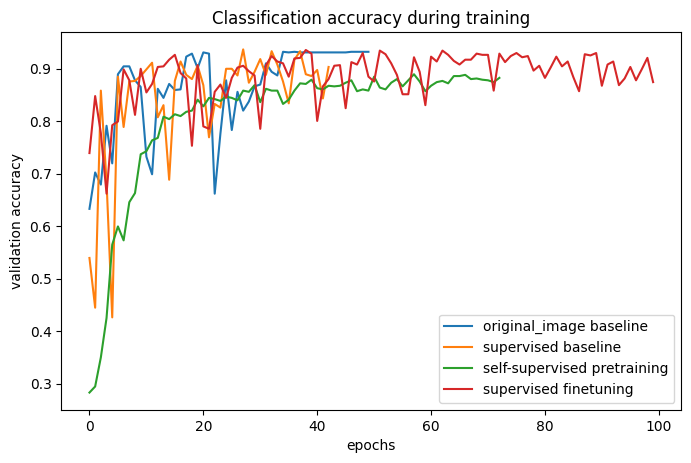

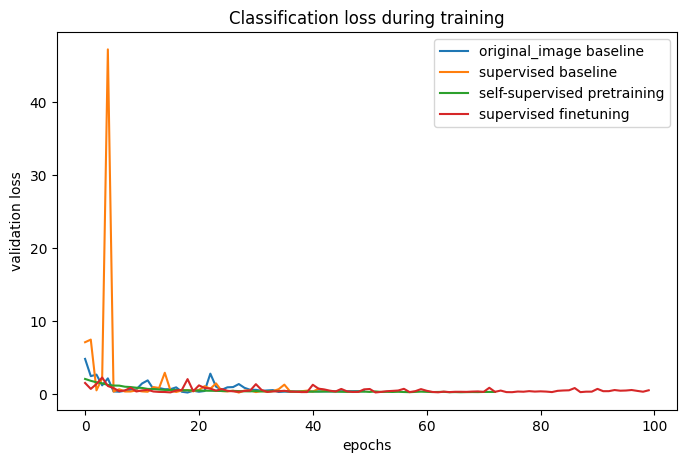

In [ ]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_model_augmenter_image_history, baseline_model_original_image_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_model_original_image_history.history[f"val_{metric_key}"], label="original_image baseline"
        )
        plt.plot(
            baseline_model_augmenter_image_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")

plot_training_curves(pretraining_history, finetuning_history, baseline_model_augmenter_image_history, baseline_model_original_image_history)

In [ ]:
print (max(baseline_model_original_image_history.history["val_acc"]) * 100)
print (max(baseline_model_augmenter_image_history.history["val_acc"]) * 100)
print (max(pretraining_history.history["val_p_acc"]) * 100)
print (max(finetuning_history.history["val_acc"]) * 100)

93.1870698928833
93.64895820617676
88.91454935073853
93.5334861278534


## 5. Model Save 

In [ ]:
save_model = keras.Sequential(
    [
        pretraining_model.encoder,
    ],
    name="pretraining_model",
)

save_model.summary()

Model: "pretraining_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 128)               21123752  
                                                                 
Total params: 21,123,752
Trainable params: 21,069,224
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
save_model.save( path_model_result + 'pretraining_model_encoder.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
save_model.save( path_model_result + 'pretraining_model_encoder.ckpt' )

INFO:tensorflow:Assets written to: gdrive/My Drive/Research_7_1_1/model_result/3 - SimCLR_model_result - 1/pretraining_model_encoder.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
